In [256]:
import matplotlib.pyplot as plt
import time
import pickle
import scipy.stats
from scipy import interpolate
from copy import copy
import pandas as pd

In [4]:
import numpy as np
import scipy.linalg as la
import numpy.linalg as nla
import numpy.matlib
import itertools

In [280]:
class GTN:
    def __init__(self,L,history=True):
        self.L=L
        self.C_m=self.correlation_matrix()
        self.C_m_history=[self.C_m]
        self.history=history
    
    def correlation_matrix(self):
        Omega=np.array([[0,1],[-1,0]])
        return np.kron(np.eye(self.L),Omega)

    
    def measure(self,n,ix):
        if not hasattr(self,'n_history'):
            self.n_history=[]
        if not hasattr(self,'i_history'):
            self.i_history=[]
            
        m=self.C_m_history[-1].copy()
        for i_ind,i in enumerate(ix):
            m[[i,-(len(ix)-i_ind)]]=m[[-(len(ix)-i_ind),i]]
            m[:,[i,-(len(ix)-i_ind)]]=m[:,[-(len(ix)-i_ind),i]]
        Gamma_LL=m[:-len(ix),:-len(ix)]
        Gamma_LR=m[:-len(ix),-len(ix):]
        Gamma_RR=m[-len(ix):,-len(ix):]
        proj=self.kraus(n)
        # proj=self.projection(s)

        Upsilon_LL=proj[:-len(ix),:-len(ix)]
        Upsilon_RR=proj[-len(ix):,-len(ix):]
        Upsilon_RL=proj[-len(ix):,:-len(ix)]
        zero=np.zeros((m.shape[0]-len(ix),len(ix)))
        zero0=np.zeros((len(ix),len(ix)))
        mat1=np.block([[Gamma_LL,zero],[zero.T,Upsilon_RR]])
        mat2=np.block([[Gamma_LR,zero],[zero0,Upsilon_RL]])
        mat3=np.block([[Gamma_RR,np.eye(len(ix))],[-np.eye(len(ix)),Upsilon_LL]])
        if np.count_nonzero(mat2):
            Psi=mat1+mat2@(la.solve(mat3,mat2.T))
            # Psi=mat1+mat2@np.linalg.inv(mat3)@mat2.T
            # Psi=mat1+mat2@(la.lstsq(mat3,mat2.T)[0])
            assert np.abs(np.trace(Psi))<1e-5, "Not trace zero {:e}".format(np.trace(Psi))
        else:
            Psi=mat1
        for i_ind,i in enumerate(ix):
            Psi[[i,-(len(ix)-i_ind)]]=Psi[[-(len(ix)-i_ind),i]]
            Psi[:,[i,-(len(ix)-i_ind)]]=Psi[:,[-(len(ix)-i_ind),i]]
        Psi=(Psi-Psi.T)/2
        if self.history:
            self.C_m_history.append(Psi)
            self.n_history.append(n)
            self.i_history.append(ix)
        else:
            self.C_m_history=[Psi]
            self.n_history=[n]
            self.i_history=[ix]

        return mat1,mat2,mat3

    def projection(self,s):
        '''
        occupancy number: s= 0,1 
        (-1)^0 even parity, (-1)^1 odd parity

        '''
        assert (s==0 or s==1),"s={} is either 0 or 1".format(s)
        blkmat=np.array([[0,-(-1)**s,0,0],
                        [(-1)**s,0,0,0],
                        [0,0,0,(-1)**s],
                        [0,0,-(-1)**s,0]])
        return blkmat

    def kraus(self,n):
        return -np.array([[0,n[0],n[1],n[2]],
                        [-n[0],0,-n[2],n[1]],
                        [-n[1],n[2],0,-n[0]],
                        [-n[2],-n[1],n[0],0]])
    

    
    def mutual_information_m(self,subregion_A,subregion_B):
        assert np.intersect1d(subregion_A,subregion_B).size==0 , "Subregion A and B overlap"
        s_A=self.von_Neumann_entropy_m(subregion_A)
        s_B=self.von_Neumann_entropy_m(subregion_B)
        subregion_AB=np.concatenate([subregion_A,subregion_B])
        s_AB=self.von_Neumann_entropy_m(subregion_AB)
        return s_A+s_B-s_AB

    def von_Neumann_entropy_m(self,subregion):
        c_A=self.c_subregion_m(subregion)
        val=nla.eigvalsh(1j*c_A)
        self.val_sh=val
        val=np.sort(val)
        val=(1-val)/2+1e-18j   #\lambda=(1-\xi)/2
        return np.real(-np.sum(val*np.log(val))-np.sum((1-val)*np.log(1-val)))/2

    def c_subregion_m(self,subregion,Gamma=None):
        if not hasattr(self,'C_m'):
            self.covariance_matrix_f()
        if Gamma is None:
            Gamma=self.C_m_history[-1]
        subregion=self.linearize_index(subregion,2)
        return Gamma[np.ix_(subregion,subregion)]


    def linearize_index(self,subregion,n,k=2,proj=False):
        try:
            subregion=np.array(subregion)
        except:
            raise ValueError("The subregion is ill-defined"+subregion)
        if proj:
            return sorted(np.concatenate([n*subregion+i for i in range(0,n,k)]))
        else:
            return sorted(np.concatenate([n*subregion+i for i in range(n)]))

    def measure_all_Born(self):
        pass

    def measure_all_forced(self,a1,a2,b1,b2,even=True,n1_z=True):
        proj_range=np.arange(self.L)*2 if even else np.arange(self.L)*2+1
        n_list=get_random(a1,a2,b1,b2,proj_range.shape[0],n1_z=n1_z)
        for i,n in zip(proj_range,n_list):
            self.measure(n, [i,(i+1)%(2*self.L)])

    def mutual_information_cross_ratio(self):
        x=np.array([0,self.L//4,self.L//2,self.L//4*3])
        MI=[]
        subA=np.arange(x[0],x[1])
        subB=np.arange(x[2],x[3])
        for shift in range(self.L//2):
            MI.append(self.mutual_information_m((subA+shift)%self.L, (subB+shift)%self.L))
        return np.mean(MI)

def get_random(a1,a2,b1,b2,num,n1_z=True):
    '''
        -b1<-a1<a2<b2 
        
        n1=True: nA=(n1,n2,n3)
        n1=True: nB=(n3,n1,n2)
    '''
    assert -b1<=-a1<=a2<=b2, "the order of -b1<-a1<a2<b2 not satisfied"
    sign=(np.random.uniform(size=num))
    n1=np.where(sign<0.5,rescale(sign,y0=-b1,y1=-a1,x0=0,x1=.5),rescale(sign,y0=a2,y1=b2,x0=.5,x1=1))

    # n1=np.random.uniform(b2,b1-a1+a2,num)
    # n1=np.where(n1<a2,n1,n1+(a1-a2))

    r=np.sqrt(1-n1**2)
    phi=np.random.uniform(0,2*np.pi,num)
    n2,n3=r*np.cos(phi),r*np.sin(phi)
    return np.c_[n1,n2,n3] if n1_z else np.c_[n3,n1,n2]

def rescale(x,y0,y1,x0=0,x1=1):
    return (y1-y0)/(x1-x0)*(x-x0)+y0

def cross_ratio(x,L):
    if L<np.inf:
        xx=lambda i,j: (np.sin(np.pi/(L)*np.abs(x[i]-x[j])))
    else:
        xx=lambda i,j: np.abs(x[i]-x[j])
    eta=(xx(0,1)*xx(2,3))/(xx(0,2)*xx(1,3))
    return eta

In [82]:
zz=get_random(a1=.5,a2= 0.25,b1= .8,b2= .8,num= 10000,n1_z=False)

(array([1334., 1313., 1336., 1036.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,  616.,  715.,  740.,  717.,  767.,
         699.,  727.]),
 array([-7.99748448e-01, -7.19762480e-01, -6.39776513e-01, -5.59790545e-01,
        -4.79804577e-01, -3.99818610e-01, -3.19832642e-01, -2.39846675e-01,
        -1.59860707e-01, -7.98747394e-02,  1.11228229e-04,  8.00971958e-02,
         1.60083163e-01,  2.40069131e-01,  3.20055099e-01,  4.00041066e-01,
         4.80027034e-01,  5.60013001e-01,  6.39998969e-01,  7.19984937e-01,
         7.99970904e-01]),
 <BarContainer object of 20 artists>)

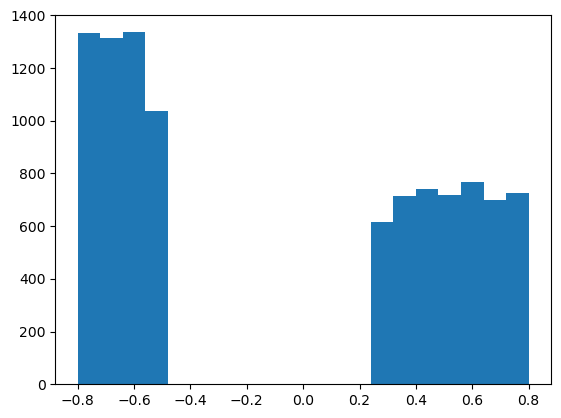

In [84]:
fig,ax=plt.subplots()
ax.hist(zz[:,1],bins=20)

In [62]:
%matplotlib inline

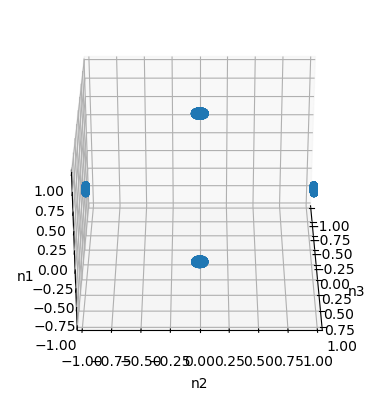

In [328]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
zz=np.array(gtn.n_history)
ax.scatter(zz[:,2],zz[:,1],zz[:,0])
ax.set_xlabel('n3')
ax.set_ylabel('n2')
ax.set_zlabel('n1')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.view_init(azim=0)


In [332]:
L=64
iteration=np.arange(100)
MI=np.zeros((iteration.shape[0],))
gtn=GTN(L=L)
for i in iteration:
    gtn.measure_all_forced(b2=1,a2= .9999, a1=.9999,b1= 1,even=True,n1_z=True)
    gtn.measure_all_forced(b2=1,a2= .9999, a1=.9999,b1= 1,even=False,n1_z=False)
    # MI[i]=(gtn.mutual_information_m(np.arange(gtn.L//2), gtn.L//2+np.arange(gtn.L//2)))
    MI[i]=gtn.mutual_information_cross_ratio()

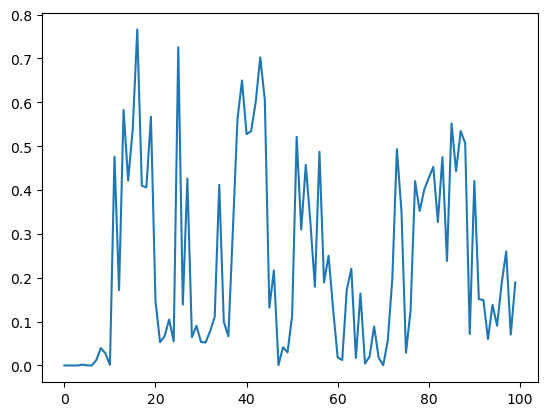

In [333]:
plt.plot(iteration,MI/np.log(2))

In [347]:
L=64
iteration=np.arange(100)
ensemble_size=20
MI=np.zeros((ensemble_size,iteration.shape[0],))
# gtn_list=[]
for ensemble in range(ensemble_size):
    gtn=GTN(L=L)
    for i in iteration:
        gtn.measure_all_forced(b2=1,a2=0, a1=.5,b1= 1,even=True,n1_z=True)
        gtn.measure_all_forced(b2=1,a2=0, a1=.5,b1= 1,even=False,n1_z=False)
        # MI[i]=(gtn.mutual_information_m(np.arange(gtn.L//2), gtn.L//2+np.arange(gtn.L//2)))
        MI[ensemble, i]=gtn.mutual_information_cross_ratio()

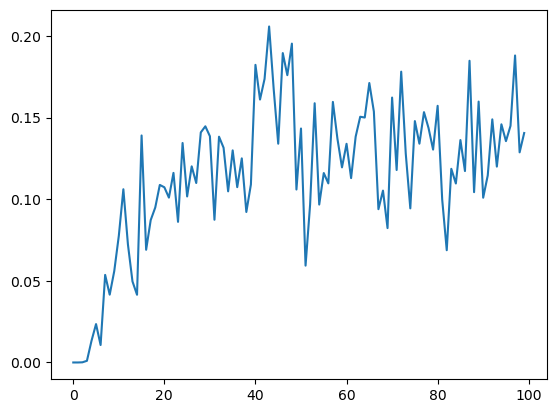

In [343]:
plt.plot(iteration,MI.mean(axis=0))

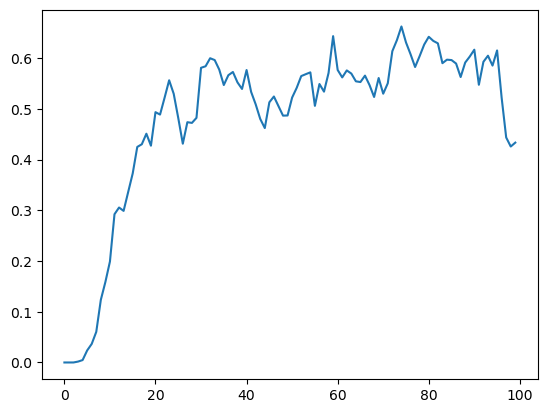

In [168]:
plt.plot(iteration,MI)

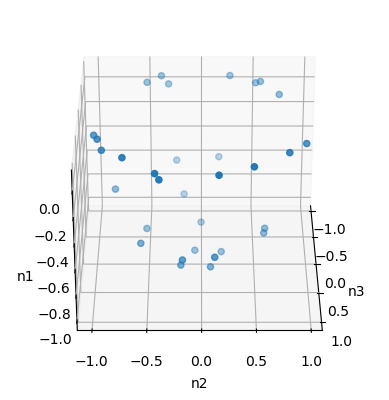

In [107]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
zz=np.array(gtn.n_history[:32])
ax.scatter(zz[:,2],zz[:,1],zz[:,0])
ax.set_xlabel('n3')
ax.set_ylabel('n2')
ax.set_zlabel('n1')
ax.view_init(azim=0)

In [309]:
gtn=GTN(L=128)
for r in range(10):
    for i in range(0,gtn.L,2):
        gtn.measure([1,0,0], [i,(i+1)%(2*gtn.L)])
    for i in range(1,gtn.L,2):
        gtn.measure([0,0,1], [i,(i+1)%(2*gtn.L)])
# gtn.measure_all_forced(b2=1,a2= 1, a1= 1,b1= 1,even=True,n1_z=True)
# mat1,mat2,mat3=gtn.measure(np.array([0,1,0]), [0,1])
# mat1,mat2,mat3=gtn.measure(np.array([-.99999,np.sqrt(1-.99999**2),0]), [0,1])

In [310]:
gtn.mutual_information_cross_ratio()

0.0

In [306]:
gtn.n_history

[[1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0,

In [271]:
mat1

array([[ 0.,  1.,  0.,  0.],
       [-1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

In [272]:
mat2

array([[ 0.,  0.,  0.,  0.],
       [-0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])

In [273]:
mat3

array([[ 0.,  1.,  1.,  0.],
       [-1.,  0.,  0.,  1.],
       [-1., -0.,  0.,  0.],
       [-0., -1.,  0.,  0.]])

In [274]:
pd.DataFrame(np.linalg.inv(mat3))

,0,1,2,3
0,-0.0,-0.0,-1.0,-0.0
1,0.0,0.0,0.0,-1.0
2,1.0,0.0,0.0,1.0
3,-0.0,1.0,-1.0,-0.0


In [275]:
gtn.n_history

[array([0, 1, 0])]

In [276]:
gtn.C_m_history

[array([[ 0.,  1.,  0.,  0.],
        [-1.,  0., -0.,  0.],
        [ 0.,  0.,  0.,  1.],
        [-0.,  0., -1.,  0.]]),
 array([[ 0.,  1.,  0.,  0.],
        [-1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.],
        [ 0.,  0., -1.,  0.]])]

In [296]:
L_list=2**np.arange(4,8)
iteration=np.arange(200)
MI=np.zeros((L_list.shape[0],iteration.shape[0]))
for L_i,L in enumerate(L_list):
    gtn=GTN(L=L)
    for i in iteration:
        gtn.measure_all_forced(b2=0.1,a2= 0, a1=.5,b1= 1,even=True,n1_z=True)
        gtn.measure_all_forced(b2=0.1,a2= 0, a1=.5,b1= 1,even=False,n1_z=False)
        MI[L_i,i]=gtn.mutual_information_cross_ratio()

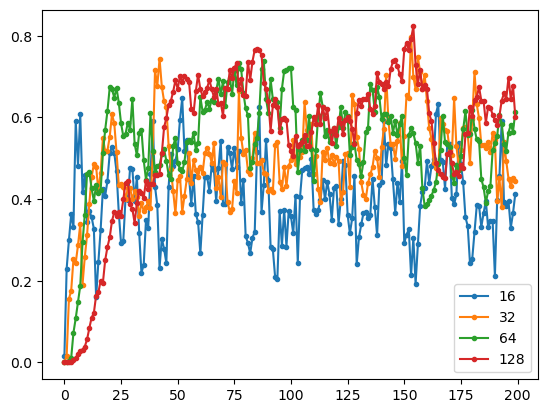

In [298]:
fig,ax=plt.subplots()
# ax.plot(L_list,np.mean(MI[:,-10:],axis=1),'.-')
for i in range(L_list.shape[0]):
    ax.plot(MI[i],'.-',label=str(L_list[i]))
ax.legend()
# ax.set_xscale('log')

In [299]:
L_list=2**np.arange(4,8)
iteration=np.arange(200)
MI_critical=np.zeros((L_list.shape[0],iteration.shape[0]))
for L_i,L in enumerate(L_list):
    gtn=GTN(L=L)
    for i in iteration:
        gtn.measure_all_forced(b2=1,a2= 0, a1=.5,b1= 1,even=True,n1_z=True)
        gtn.measure_all_forced(b2=1,a2= 0, a1=.5,b1= 1,even=False,n1_z=False)
        MI_critical[L_i,i]=gtn.mutual_information_cross_ratio()

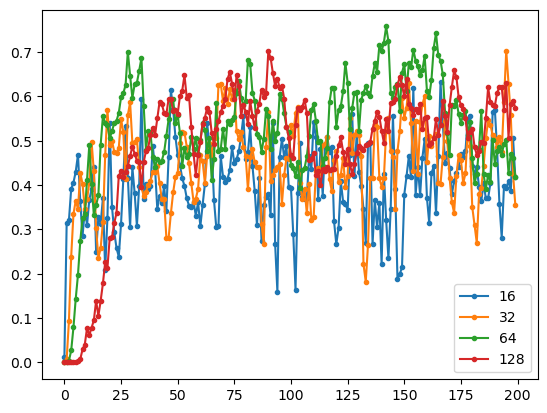

In [300]:
fig,ax=plt.subplots()
# ax.plot(L_list,np.mean(MI_critical[:,-10:],axis=1),'.-')
for i in range(L_list.shape[0]):
    ax.plot(MI_critical[i],'.-',label=str(L_list[i]))
ax.legend()
# ax.set_xscale('log')

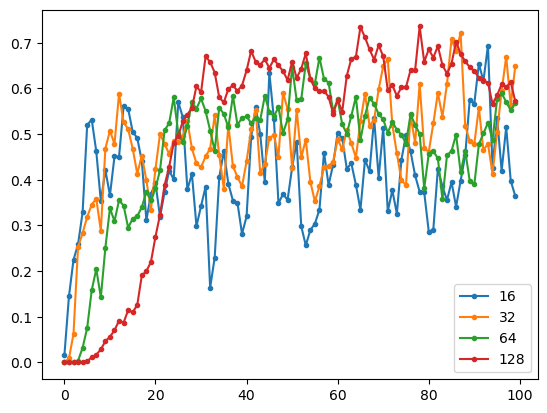

In [192]:
fig,ax=plt.subplots()
# ax.plot(L_list,np.mean(MI_critical[:,-10:],axis=1),'.-')
for i in range(L_list.shape[0]):
    ax.plot(MI_critical[i],'.-',label=str(L_list[i]))
ax.legend()
# ax.set_xscale('log')

In [255]:
gtn.measure(np.array([1,0,0]), [0,1])

In [257]:
gtn.measure(np.array([1,1,0]), [0,1])

In [285]:
# gtn.measure_all_forced(b2=-.9,a2= -.7, a1=.7,b1= .9)
gtn.measure_all_forced(b2=-.9,a2= -.7, a1=.7,b1= .9,even=False)

In [283]:
gtn.n_history

[array([ 0.70708212, -0.6158029 ,  0.34759411]),
 array([ 0.71292935, -0.07927067,  0.69674092]),
 array([-0.73656885,  0.6753321 ,  0.03732137]),
 array([-0.87550474, -0.06941651, -0.47819745])]

In [209]:
np.round(gtn.kraus(gtn.n_history[0]))

array([[-0.,  1., -0., -0.],
       [-1., -0.,  0., -0.],
       [ 0., -0., -0., -1.],
       [ 0.,  0.,  1., -0.]])

In [288]:
gtn.mutual_information_m([0,1],[2,3])/np.log(2)

2.718401573307823

In [286]:
gtn.C_m_history

[array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [-1.,  0., -0.,  0., -0.,  0., -0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [-0.,  0., -1.,  0., -0.,  0., -0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
        [-0.,  0., -0.,  0., -1.,  0., -0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [-0.,  0., -0.,  0., -0.,  0., -1.,  0.]]),
 array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.]]),
 array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0

In [287]:
np.round(gtn.C_m_history[-1]@gtn.C_m_history[-1]+np.eye(gtn.C_m_history[-1].shape[0]),4)

array([[ 0., -0., -0., -0.,  0., -0.,  0., -0.],
       [-0.,  0.,  0.,  0., -0.,  0., -0., -0.],
       [-0.,  0.,  0.,  0., -0.,  0., -0.,  0.],
       [-0.,  0.,  0.,  0., -0., -0., -0., -0.],
       [ 0., -0., -0., -0.,  0., -0.,  0., -0.],
       [-0.,  0.,  0., -0., -0.,  0., -0.,  0.],
       [ 0., -0., -0., -0.,  0., -0.,  0.,  0.],
       [-0., -0.,  0., -0., -0.,  0.,  0.,  0.]])

In [154]:
zz=gtn.get_random(b2=-.8,a2= -.2, a1=.6,b1= .8,n= 100)

In [155]:
zz

array([[ 0.70119751,  0.22109219, -0.67782025],
       [-0.47606129, -0.85122594,  0.22086206],
       [-0.54611007,  0.83747523, -0.01997562],
       [-0.6676215 ,  0.65284639, -0.35787306],
       [ 0.64531027, -0.53599815,  0.54431667],
       [ 0.66289005,  0.70583412, -0.24974982],
       [-0.40978067,  0.60542324,  0.68230675],
       [-0.6123901 ,  0.36461803, -0.70144997],
       [-0.60270724,  0.2228029 , -0.76622637],
       [-0.38271209, -0.07799474,  0.92056954],
       [-0.26409525, -0.80819312,  0.52638159],
       [-0.601173  ,  0.7936046 , -0.09371639],
       [-0.67677914, -0.56841175, -0.46784407],
       [ 0.65793901, -0.70672265, -0.2601141 ],
       [-0.29417646, -0.6118983 ,  0.7341939 ],
       [ 0.68633131,  0.32151399, -0.65236346],
       [-0.43842451, -0.8666208 ,  0.2382275 ],
       [-0.62234816,  0.28399222,  0.72940468],
       [-0.77429458, -0.57677726,  0.26037644],
       [-0.23630149, -0.3956249 ,  0.88749228],
       [-0.67793996,  0.00213845, -0.735

In [156]:
np.linalg.norm(zz,axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

(array([646., 675., 635., 655., 646., 684., 672., 722., 665., 636., 689.,
        162.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0., 511., 678., 641., 683.]),
 array([-7.99993005e-01, -7.46663848e-01, -6.93334691e-01, -6.40005535e-01,
        -5.86676378e-01, -5.33347221e-01, -4.80018065e-01, -4.26688908e-01,
        -3.73359751e-01, -3.20030595e-01, -2.66701438e-01, -2.13372281e-01,
        -1.60043125e-01, -1.06713968e-01, -5.33848111e-02, -5.56544542e-05,
         5.32735022e-02,  1.06602659e-01,  1.59931816e-01,  2.13260972e-01,
         2.66590129e-01,  3.19919286e-01,  3.73248442e-01,  4.26577599e-01,
         4.79906756e-01,  5.33235912e-01,  5.86565069e-01,  6.39894226e-01,
         6.93223383e-01,  7.46552539e-01,  7.99881696e-01]),
 <BarContainer object of 30 artists>)

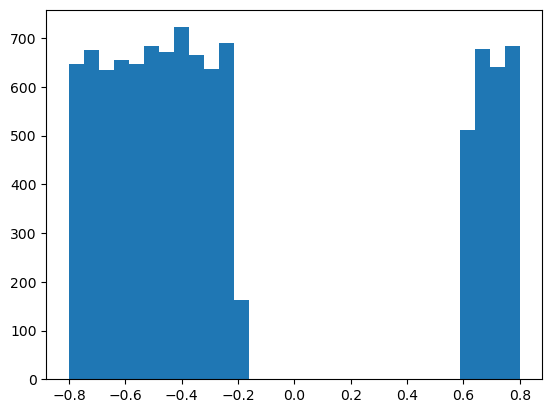

In [124]:
plt.hist(zz,30)

In [97]:
gtn.kraus(np.array([1,0,0]),theta=0)

array([[ 0.,  1.,  0.,  0.],
       [-1.,  0., -0.,  0.],
       [-0.,  0.,  0., -1.],
       [-0., -0.,  1.,  0.]])

In [77]:
gtn.C_m

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  0., -0.,  0., -0.,  0., -0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [-0.,  0., -1.,  0., -0.,  0., -0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [-0.,  0., -0.,  0., -1.,  0., -0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [-0.,  0., -0.,  0., -0.,  0., -1.,  0.]])

In [67]:
gtn.C_m=np.array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [72]:
gtn.C_m_history=[np.array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])]

In [56]:
gtn.measure(0, [0,1])

In [57]:
gtn.i_history

[[0, 1], [0, 1]]

In [73]:
gtn.C_m_history

[array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
        [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])]

In [25]:
gtn.measure(0, [0,1])

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  0., -0.,  0., -0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0., -0.,  0., -1.,  0., -0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0., -0.,  0., -0.,  0., -1.,  0.]])

In [19]:
gtn.measure(1, [1,2])

array([[ 0.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.]])

In [60]:
gtn.von_Neumann_entropy_m([0,1])

In [75]:
gtn.mutual_information_m([0,1],[2,3])/np.log(2)

2.0